In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
from pathlib import Path
import itertools
import pickle
import seaborn as sns
import jax
import jax.numpy as np
import numpy
import scipy
import seaborn as sns
jax.config.update('jax_platform_name', 'cpu')
os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=16'

In [3]:
from sklearn.cluster import MiniBatchKMeans

In [4]:
from bomtemplate.bd_transformation import fc_phases_space, fc_space, activity_space
from bomtemplate.into_states import clustering
from bomtemplate.reliability_assessment import fingerprinting
from bomtemplate import utility
from bomtemplate import bd_preprocessing

In [5]:
cwd = os.getcwd()
head = Path(cwd).parents[1]
path_data = os.path.join(head, 'saved_data/')

In [6]:
getdata = bd_preprocessing.Get_1000Brains_Data(path_data)
output_dict = getdata.get_data(bins=False)
output_dict.keys()

dict_keys(['data_3d', 'ages', 'TR', 'transient'])

In [7]:
transient = output_dict['transient']
data_3d = output_dict['data_3d'][:,transient:]
n_participants, n_samples, n_nodes = data_3d.shape

In [8]:
lowcut = 0.01
highcut = 0.08
data_3d_filtered = np.zeros_like(data_3d)
for p in range(n_participants):
    data_3d_filtered = data_3d_filtered.at[p].set(bd_preprocessing.butter_bandpass_filter(data_3d[p], axis=0, lowcut=lowcut, highcut=highcut, fs=1, order=1))

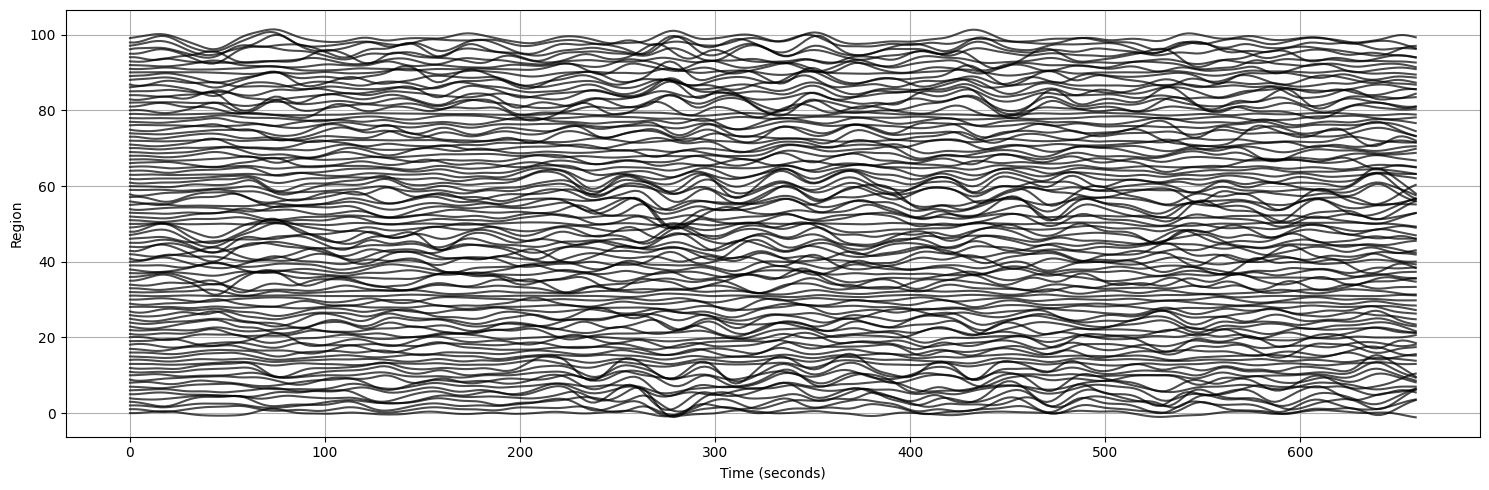

In [9]:
TR = output_dict['TR']
bd_preprocessing.plot_filtered_ts(data_3d_filtered[9], TR=TR)

### thresholded data, like chinese paper

#### step 1: transform the data

In [10]:
h=30

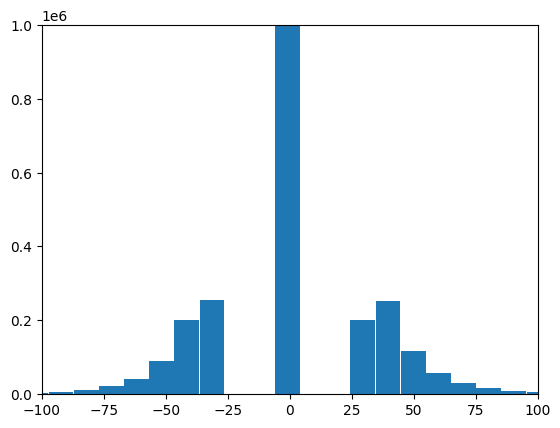

In [11]:
est_thr = activity_space.Thresholding().fit(X = data_3d)
data_thr = est_thr.transform(data_3d, threshold=h)
counts, edges = np.histogram(data_thr.ravel(), bins=200)
centers = (edges[1:]+ edges[:-1])/2
bar(centers, counts, width=10)
ylim(0,1e6)
xlim(-100,100);

#### step 2: cluster into recurrent objects (states)

In [12]:
n_states = 8
part = getdata.split_test_retest(removed_transient=1)
xtest = data_thr[:,:part]
xretest = data_thr[:,-part:]

In [13]:
xtest.shape, xretest.shape

((648, 133, 100), (648, 133, 100))

In [14]:
k = clustering.Cluster()
kmeans = MiniBatchKMeans(n_clusters=n_states, n_init='auto')
xtest = xtest.reshape(-1, n_nodes)
xretest = xretest.reshape(-1, n_nodes)
k.fit(xtest, kmeans)
telab_grouped  = k.predict(xtest).reshape(n_participants,-1)
retelab_grouped  = k.predict(xretest).reshape(n_participants,-1)


#### step 3: reliability assessment

In [15]:
f = fingerprinting.Fingerprinting()
f.fit_occurence_ratio(telab_grouped, retelab_grouped)
permuted_statistics, observed_statistic, p_value = f.intersim_vs_intrasim(1000)

100%|██████████| 1000/1000 [00:00<00:00, 3343.52it/s]


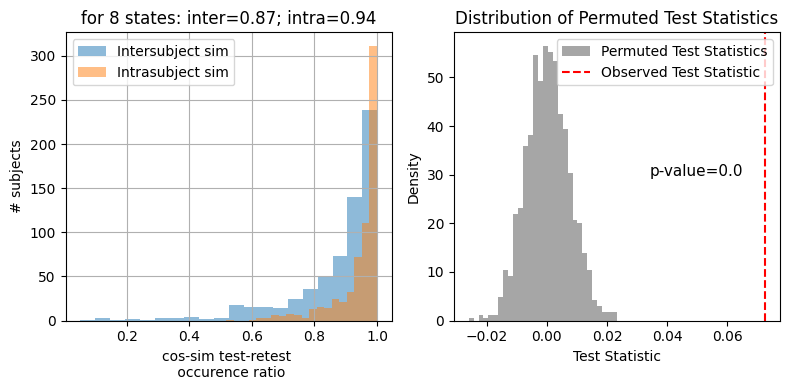

In [16]:
figure(figsize=(8,4))
subplot(121)
hist(f.intersim, 20, label='Intersubject sim', alpha=0.5)
hist(f.intrasim, 20, label='Intrasubject sim', alpha=0.5)
xlabel('cos-sim test-retest \n occurence ratio'); ylabel('# subjects'); grid(1);
title(f'for {n_states} states: inter={f.intersim.mean():0.2f}; intra={f.intrasim.mean():0.2f}')
legend()
subplot(122)
hist(permuted_statistics, bins=30, density=True, alpha=0.7, color='grey', label='Permuted Test Statistics')
axvline(x=observed_statistic, color='red', linestyle='--', label='Observed Test Statistic')
annotate(rf'p-value={p_value}',
                   xy=(0.6, 0.5), xycoords='axes fraction', fontsize=11)
xlabel('Test Statistic')
ylabel('Density')
title('Distribution of Permuted Test Statistics')
legend()
tight_layout()
show()

#### step 4: predictive power

In [17]:
train_idx, test_idx = getdata.split_train_test()

In [18]:
xtrain = data_thr[train_idx].copy()
xtest = data_thr[test_idx].copy()

In [19]:
k = clustering.Cluster()
kmeans = MiniBatchKMeans(n_clusters=n_states, n_init='auto')
xtrain = xtrain.reshape(-1, n_nodes)
xtest = xtest.reshape(-1, n_nodes)
k.fit(xtrain, kmeans)
trlab_grouped  = k.predict(xtrain).reshape(train_idx.size,-1)
telab_grouped  = k.predict(xtest).reshape(test_idx.size,-1)

In [20]:
f = fingerprinting.Fingerprinting()
f.fit_occurence_ratio(trlab_grouped, telab_grouped)
ages = output_dict["ages"]
a = f.X_[:,0][:,None]
y = f.y_[:,0][:,None]@np.linalg.lstsq(a, ages[train_idx], rcond=None)[0]
y.shape, ages[test_idx].shape
predictors, r_values, p_values = f.regression(ages[train_idx], ages[test_idx])

In [21]:
r_values, p_values

(Array([ 0.01461979, -0.0685455 ,  0.05402079,  0.02499329,  0.00621069,
         0.0170451 ,  0.23582456, -0.04606262, -0.04664048], dtype=float32),
 Array([0.86785793, 0.43482804, 0.538424  , 0.77605456, 0.94365454,
        0.84618783, 0.00648582, 0.5999557 , 0.5953836 ], dtype=float32))

(Text(0, 0.5, 'true age'), Text(0.5, 0, 'predicted age'))

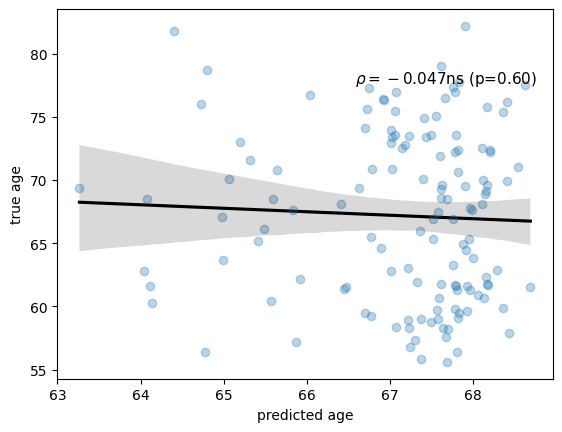

In [22]:
y = predictors[-1,:]
sns.regplot(x=y, y=ages[test_idx],
            line_kws=dict(color="k",zorder=0), ci=95, scatter_kws={"alpha": 0.3})
slope,_,r_value,p_value,_ = scipy.stats.linregress(x=y, y=ages[test_idx])
annotate(rf'$\rho={r_value.round(3)}${utility.convert_pvalue_to_asterisks(p_value)} (p={p_value:0.02f})',
         xy=(0.6, 0.8), xycoords='axes fraction', fontsize=11)
ylabel('true age'), xlabel('predicted age')

**Note:** which is  subject to the initialization of the kmeans

### Zudah

#### step 1: transform the data

In [23]:
est_zudah = fc_phases_space.Zudah().fit(X=data_3d_filtered)
zudah = est_zudah.transform(data_3d_filtered)

In [24]:
zudah.shape[-1]

4950

#### step 2: cluster into recurrent objects (states)

In [25]:
n_states = 8
xtest = zudah[:,:part]
xretest = zudah[:,-part:]

In [26]:
k = clustering.Cluster()
kmeans = MiniBatchKMeans(n_clusters=n_states, n_init='auto')
xtest = xtest.reshape(-1, est_zudah.n_features)
xretest = xretest.reshape(-1, est_zudah.n_features)
k.fit(xtest, kmeans)
telab_grouped  = k.predict(xtest).reshape(n_participants,-1)
retelab_grouped  = k.predict(xretest).reshape(n_participants,-1)


#### step 3: reliability assessment

In [27]:
f = fingerprinting.Fingerprinting()
f.fit_occurence_ratio(telab_grouped, retelab_grouped)
permuted_statistics, observed_statistic, p_value = f.intersim_vs_intrasim(1000)

100%|██████████| 1000/1000 [00:00<00:00, 3716.29it/s]


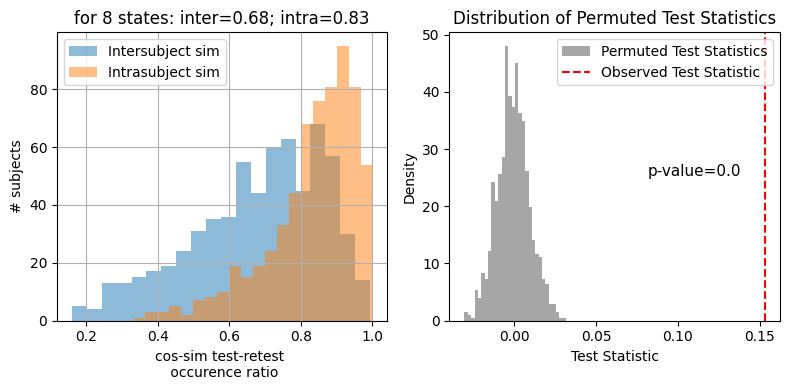

In [28]:
figure(figsize=(8,4))
subplot(121)
hist(f.intersim, 20, label='Intersubject sim', alpha=0.5)
hist(f.intrasim, 20, label='Intrasubject sim', alpha=0.5)
xlabel('cos-sim test-retest \n occurence ratio'); ylabel('# subjects'); grid(1);
title(f'for {n_states} states: inter={f.intersim.mean():0.2f}; intra={f.intrasim.mean():0.2f}')
legend()
subplot(122)
hist(permuted_statistics, bins=30, density=True, alpha=0.7, color='grey', label='Permuted Test Statistics')
axvline(x=observed_statistic, color='red', linestyle='--', label='Observed Test Statistic')
annotate(rf'p-value={p_value}',
                   xy=(0.6, 0.5), xycoords='axes fraction', fontsize=11)
xlabel('Test Statistic')
ylabel('Density')
title('Distribution of Permuted Test Statistics')
legend()
tight_layout()
show()

#### step 4: predictive power

In [30]:
train_idx, test_idx = getdata.split_train_test()

In [31]:
xtrain = zudah[train_idx].copy()
xtest = zudah[test_idx].copy()

In [38]:
print(__spec__)

None


In [32]:
k = clustering.Cluster()
kmeans = MiniBatchKMeans(n_clusters=n_states, n_init='auto')
xtrain = xtrain.reshape(-1, n_nodes)
xtest = xtest.reshape(-1, n_nodes)
k.fit(xtrain, kmeans)
trlab_grouped  = k.predict(xtrain).reshape(train_idx.size,-1)
telab_grouped  = k.predict(xtest).reshape(test_idx.size,-1)

In [33]:
f = fingerprinting.Fingerprinting()
f.fit_occurence_ratio(trlab_grouped, telab_grouped)
ages = output_dict["ages"]
a = f.X_[:,0][:,None]
y = f.y_[:,0][:,None]@np.linalg.lstsq(a, ages[train_idx], rcond=None)[0]
y.shape, ages[test_idx].shape
predictors, r_values, p_values = f.regression(ages[train_idx], ages[test_idx])

In [34]:
r_values, p_values

(Array([ 0.12992753,  0.19379088, -0.2929417 ,  0.18025215, -0.16408552,
         0.29780617, -0.16470958, -0.14012411,  0.22408104], dtype=float32),
 Array([0.1375816 , 0.02598325, 0.00065266, 0.03861983, 0.06010371,
        0.0005243 , 0.05912249, 0.10904329, 0.00979619], dtype=float32))

(Text(0, 0.5, 'true age'), Text(0.5, 0, 'predicted age'))

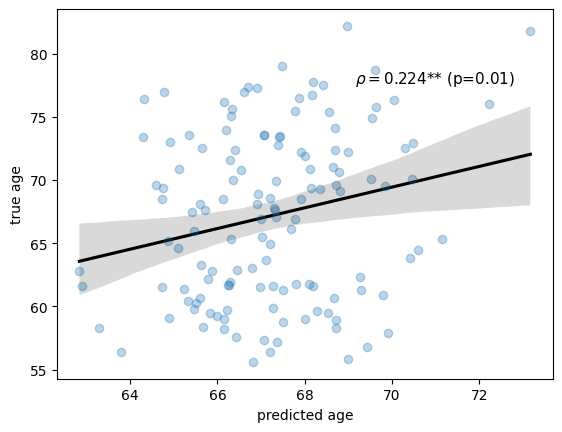

In [35]:
y = predictors[-1,:]
sns.regplot(x=y, y=ages[test_idx],
            line_kws=dict(color="k",zorder=0), ci=95, scatter_kws={"alpha": 0.3})
slope,_,r_value,p_value,_ = scipy.stats.linregress(x=y, y=ages[test_idx])
annotate(rf'$\rho={r_value.round(3)}${utility.convert_pvalue_to_asterisks(p_value)} (p={p_value:0.02f})',
         xy=(0.6, 0.8), xycoords='axes fraction', fontsize=11)
ylabel('true age'), xlabel('predicted age')